In [1]:
import matplotlib.pyplot as plt
import numpy as np
import diagnostics

In [2]:
exp = diagnostics.plume('../../data/Nyles/plume_ref4/', 'plume_ref4')
exp.params

{'modelname': 'LES',
 'geometry': 'closed',
 'Lx': 4000.0,
 'Ly': 4000.0,
 'Lz': 2000.0,
 'n_tracers': 0,
 'unit_length': 'm',
 'unit_duration': 's',
 'rotating': True,
 'forced': True,
 'coriolis': 0.0001,
 'diff_coef': {},
 'datadir': '/home1/scratch/groullet/data/Nyles',
 'expname': 'plume_ref4',
 'mode': 'overwrite',
 'variables_in_history': ['b', 'u'],
 'timestep_history': 600.0,
 'simplified_grid': True,
 'include_halo': False,
 'disk_space_warning': 0.5,
 'show': False,
 'iterations_per_frame': 4,
 'style': 'b-interface',
 'stable_stratification': False,
 'aspect': 'equal',
 'rotation_speed': 3,
 'tend': 86400.0,
 'timestepping': 'LFAM3',
 'auto_dt': True,
 'dt': 200.0,
 'cfl': 0.8,
 'dt_max': 200.0,
 'global_nx': 32,
 'global_ny': 32,
 'global_nz': 16,
 'orderVF': 5,
 'orderKE': 5,
 'orderA': 5,
 'npx': 2,
 'npy': 2,
 'npz': 1,
 'nh': 3,
 'npre': 3,
 'npost': 3,
 'ndeepest': 20,
 'omega': 0.8,
 'tol': 0.001,
 'maxite': 20,
 'nglue': 1,
 'ncellscoarsest': 32,
 'nx': 16,
 'ny': 1

In [30]:
variables = exp.read_vars(['b', 'v'])

In [31]:
KE = exp.kinetic_energy()

In [32]:
KE.shape

(145, 16, 32, 32)

Text(0.5, 1.0, 'b')

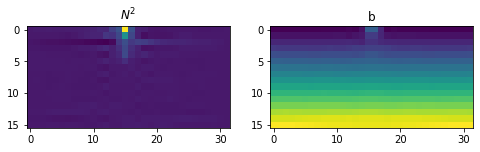

In [35]:
nz = 13
t = 143
plt.figure(figsize=(8,6))
plt.subplot(121)
im1 = plt.imshow(variables['v'][t, :, :,16])
#plt.colorbar(im1)
plt.title(r'$N^2$')

plt.subplot(122)
im2 = plt.imshow(variables['b'][t,:,:,16])
plt.title('b')
#plt.colorbar(im2)

# forced_plume_32z_00_hist.nc

In [53]:
4000/64

62.5

In [54]:
2000/32

62.5

In [36]:
exp = diagnostics.plume('../../data/Nyles/forced_plume_32z/', 'forced_plume_32z')
exp.params

{'modelname': 'LES',
 'geometry': 'closed',
 'Lx': 4000.0,
 'Ly': 4000.0,
 'Lz': 2000.0,
 'n_tracers': 0,
 'unit_length': 'm',
 'unit_duration': 's',
 'rotating': True,
 'forced': True,
 'coriolis': 0.0001,
 'diff_coef': {},
 'datadir': '~/data/Nyles',
 'expname': 'forced_plume_32z',
 'mode': 'overwrite',
 'variables_in_history': ['b', 'u'],
 'timestep_history': 600.0,
 'simplified_grid': True,
 'include_halo': False,
 'disk_space_warning': 0.5,
 'show': False,
 'iterations_per_frame': 4,
 'style': 'b-interface',
 'stable_stratification': False,
 'aspect': 'equal',
 'rotation_speed': 3,
 'tend': 86400.0,
 'timestepping': 'LFAM3',
 'auto_dt': True,
 'dt': 200.0,
 'cfl': 0.8,
 'dt_max': 200.0,
 'global_nx': 64,
 'global_ny': 64,
 'global_nz': 32,
 'orderVF': 5,
 'orderKE': 5,
 'orderA': 5,
 'npx': 1,
 'npy': 1,
 'npz': 1,
 'nh': 3,
 'npre': 3,
 'npost': 3,
 'ndeepest': 20,
 'omega': 0.8,
 'tol': 0.001,
 'maxite': 20,
 'nglue': 1,
 'ncellscoarsest': 32,
 'nx': 64,
 'ny': 64,
 'nz': 32,
 '

In [60]:
variables = exp.read_vars(['x', 'y', 'z', 'KE'])

In [61]:
x = variables['x']
y = variables['y']
z = variables['z']

XZ, ZX = np.meshgrid(x, z)
XY, YX = np.meshgrid(x, y)

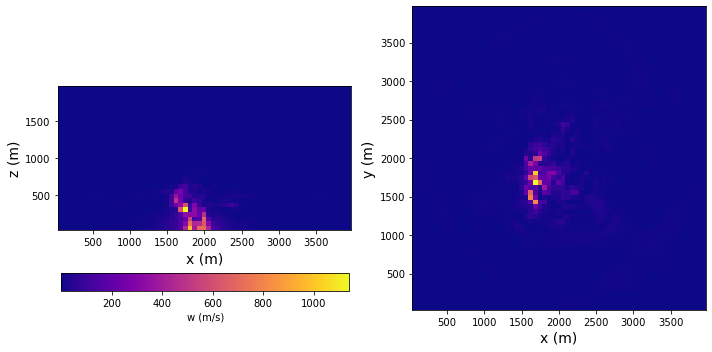

In [64]:
field = variables['KE']#/62.5

n = 70
maxx = 10
minn = -10

fig = plt.figure(figsize=(10,5), tight_layout=True)
ax1 = plt.subplot(121, aspect='equal')
im = ax1.pcolormesh(XZ, ZX, field[n, :, 32, :], cmap='plasma')#, vmax=maxx, vmin=minn)
#ax1.text(2700, 2100, f't = {t[n]/3600:.2f} h', c='black', fontsize=14)
#ax1.text(200, 2100, f'y = {y[32]:.0f} m', c='black', fontsize=14)
ax1.set_xlabel('x (m)', fontsize=14)
ax1.set_ylabel('z (m)', fontsize=14)

ax2 = plt.subplot(122)
ax2.pcolormesh(XY, YX, field[n, 10, :, :], cmap='plasma')#,  vmax=maxx, vmin=minn)
#ax2.text(2650, 3600, f'z = {z[16]:.0f} m', c='white', fontsize=14)
ax2.set_xlabel('x (m)', fontsize=14)
ax2.set_ylabel('y (m)', fontsize=14)

cbaxes = fig.add_axes([0.09, 0.18, 0.4, 0.05]) 
cb = plt.colorbar(im, cax = cbaxes, orientation='horizontal', label='w (m/s)') 

#plt.tight_layout()